### Prereqs (setup, subsampled data, dual views)

In [3]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
print("✅ setup ready")


✅ setup ready


In [4]:
# === PART 0.B — Load CIFAR-10 & SUBSAMPLE for speed, then prepare two views (LR vs GAN) ===

# 1) Load
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()
y_train_full = y_train_full.flatten()
y_test_full  = y_test_full.flatten()

# 2) Subsample: 1,000 train & 200 test per class (~10k/2k total)
def subsample_by_class(X, y, n_per_class):
    Xs, ys = [], []
    for c in range(10):
        idx = np.where(y==c)[0][:n_per_class]
        Xs.append(X[idx]); ys.append(y[idx])
    return np.concatenate(Xs, axis=0), np.concatenate(ys, axis=0)

X_train, y_train = subsample_by_class(X_train_full, y_train_full, 1000)
X_test,  y_test  = subsample_by_class(X_test_full,  y_test_full,  200)
print("Train:", X_train.shape, y_train.shape, " Test:", X_test.shape, y_test.shape)

# 3) Dual preprocessing
#    (A) LR view: [0,1] -> flatten -> PCA(256)
X_train_lr = (X_train.astype(np.float32)/255.0).reshape(len(X_train), -1)
X_test_lr  = (X_test.astype(np.float32)/255.0 ).reshape(len(X_test),  -1)

pca = PCA(n_components=256, whiten=True, random_state=42)
X_train_lr_pca = pca.fit_transform(X_train_lr)
X_test_lr_pca  = pca.transform(X_test_lr)
print("LR features:", X_train_lr_pca.shape, X_test_lr_pca.shape)

#    (B) GAN view: [-1,1]
X_train_gan = (X_train.astype(np.float32)/127.5) - 1.0
X_test_gan  = (X_test.astype(np.float32)/127.5 ) - 1.0
print("GAN range:", float(X_train_gan.min()), float(X_train_gan.max()))


Train: (10000, 32, 32, 3) (10000,)  Test: (2000, 32, 32, 3) (2000,)
LR features: (10000, 256) (2000, 256)
GAN range: -1.0 1.0


# Part 1 — Discriminative Model (Logistic Regression) + Extensions
#### 1.1 Logistic Regression (baseline) — accuracy & confusion matrix (Required)

C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LR] CIFAR-10 (subsample) test accuracy: 0.3755


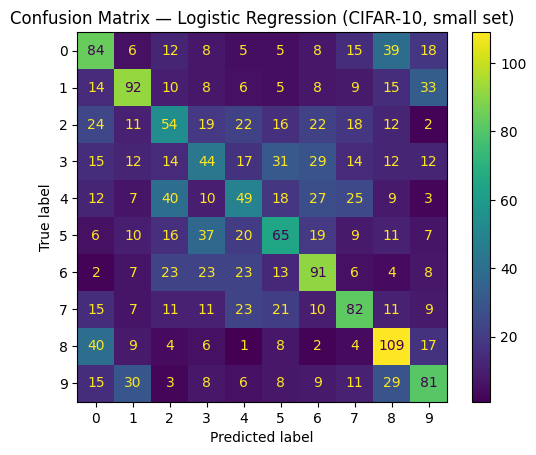


Classification Report (optional):
              precision    recall  f1-score   support

           0       0.37      0.42      0.39       200
           1       0.48      0.46      0.47       200
           2       0.29      0.27      0.28       200
           3       0.25      0.22      0.24       200
           4       0.28      0.24      0.26       200
           5       0.34      0.33      0.33       200
           6       0.40      0.46      0.43       200
           7       0.42      0.41      0.42       200
           8       0.43      0.55      0.48       200
           9       0.43      0.41      0.42       200

    accuracy                           0.38      2000
   macro avg       0.37      0.38      0.37      2000
weighted avg       0.37      0.38      0.37      2000



In [5]:
lr = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="saga", n_jobs=-1)
lr.fit(X_train_lr_pca, y_train)

y_pred = lr.predict(X_test_lr_pca)
lr_acc = accuracy_score(y_test, y_pred)
print(f"[LR] CIFAR-10 (subsample) test accuracy: {lr_acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix — Logistic Regression (CIFAR-10, small set)')
plt.savefig('cifar10_lr_confusion.png', dpi=200, bbox_inches='tight')
plt.show()

print("\nClassification Report (optional):")
print(classification_report(y_test, y_pred))


#### 1.2 Train a Non-linear Classifier (SVM + Decision Tree) — compare vs LR (Required)

In [6]:
# SVM (RBF) on a smaller subset to keep it fast
svm_n = 5000
rng = np.random.default_rng(42)
idx = rng.choice(len(X_train_lr_pca), size=svm_n, replace=False)
svm = SVC(kernel='rbf', C=2.0, gamma='scale')
svm.fit(X_train_lr_pca[idx], y_train[idx])
svm_acc = accuracy_score(y_test, svm.predict(X_test_lr_pca))

# Decision Tree (cap depth to reduce overfitting)
tree = DecisionTreeClassifier(max_depth=30, random_state=42)
tree.fit(X_train_lr_pca, y_train)
tree_acc = accuracy_score(y_test, tree.predict(X_test_lr_pca))

print(f"Compare — LR:{lr_acc:.4f} | SVM:{svm_acc:.4f} | Tree:{tree_acc:.4f}")


Compare — LR:0.3755 | SVM:0.4100 | Tree:0.2100


#### 1.3 Regularization Experiment — L1 vs L2 (Required)

In [7]:
def run_lr_reg(penalty, C=1.0):
    clf = LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga",
                             penalty=penalty, C=C, n_jobs=-1, random_state=42, tol=1e-3)
    clf.fit(X_train_lr_pca, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_lr_pca))
    return clf, acc

lr_l2, acc_l2 = run_lr_reg("l2", C=1.0)
lr_l1, acc_l1 = run_lr_reg("l1", C=1.0)
print(f"[LR L2] acc={acc_l2:.4f} | [LR L1] acc={acc_l1:.4f}  (C=1.0)")


C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LR L2] acc=0.3755 | [LR L1] acc=0.3750  (C=1.0)


#### 1.4 Feature Importance Visualization — per-class heatmaps (Required)

Back-project LR weights from PCA space → pixel space (32×32).

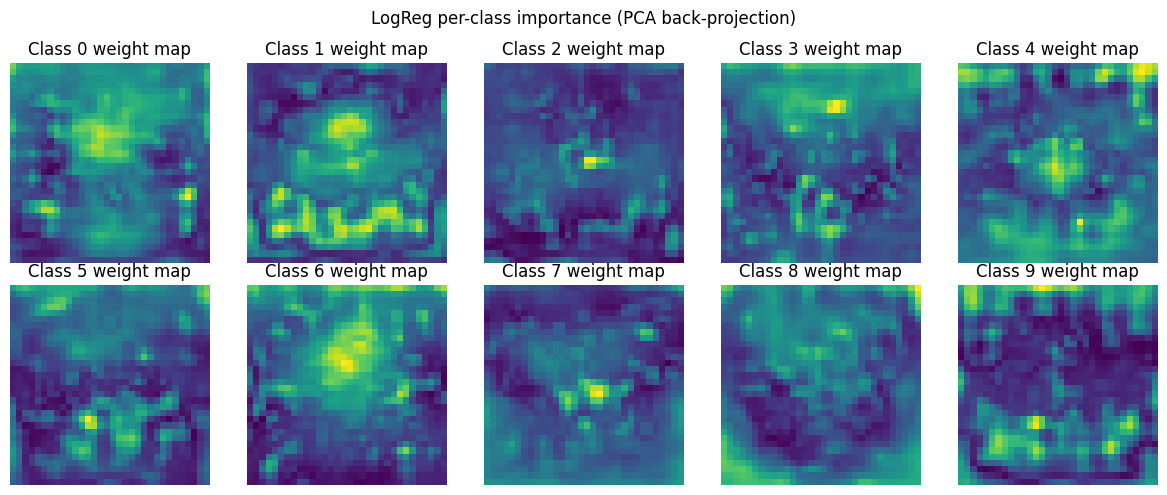

In [8]:
W_pca = lr.coef_                  # (10, 256)
W_pix = W_pca @ pca.components_   # (10, 3072)
W_pix_imgs = W_pix.reshape(10, 32, 32, 3)

# Collapse channels -> single heatmap via abs-sum
W_import = np.abs(W_pix_imgs).sum(axis=-1)  # (10, 32, 32)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()
for c in range(10):
    axes[c].imshow(W_import[c], interpolation='nearest')
    axes[c].set_title(f"Class {c} weight map")
    axes[c].axis('off')
plt.suptitle("LogReg per-class importance (PCA back-projection)")
plt.tight_layout()
plt.savefig('cifar10_lr_importance_maps.png', dpi=200, bbox_inches='tight')
plt.show()


#### 1.5 Cross-Validation — 5-fold (Required)

In [9]:
pipe = Pipeline([
    ("pca", PCA(n_components=256, whiten=True, random_state=42)),
    ("lr", LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga", n_jobs=-1))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train_lr, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"[LR 5-fold CV] mean={scores.mean():.4f}, std={scores.std():.4f}, scores={np.round(scores,4)}")


[LR 5-fold CV] mean=0.3685, std=0.0136, scores=[0.3855 0.3835 0.3625 0.36   0.351 ]


# Part 2 — Generative Model (GAN) + Extensions
#### 2.0 Build GAN (baseline) — small DCGAN-ish (Required)

In [10]:
latent_dim = 128

def make_generator(g_base=256, use_bn=False):
    G = models.Sequential(name=f"Generator_g{g_base}{'_bn' if use_bn else ''}")
    G.add(layers.Input(shape=(latent_dim,)))
    G.add(layers.Dense(8*8*g_base))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Reshape((8,8,g_base)))
    G.add(layers.Conv2DTranspose(g_base//2, 4, strides=2, padding='same'))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Conv2DTranspose(g_base//4, 4, strides=2, padding='same'))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Conv2D(3, 3, padding='same', activation='tanh'))
    return G

def make_discriminator(d_base=64, drop=0.25, deeper=False):
    D = models.Sequential(name=f"Discriminator_d{d_base}{'_deep' if deeper else ''}")
    D.add(layers.Input(shape=(32,32,3)))
    D.add(layers.Conv2D(d_base,   3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    D.add(layers.Conv2D(d_base*2, 3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    if deeper:
        D.add(layers.Conv2D(d_base*4, 3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    D.add(layers.Flatten())
    D.add(layers.Dense(1, activation='sigmoid'))
    return D

def build_gan(lr_g=1e-4, lr_d=1e-4, g_base=256, d_base=64, use_bn=False, deeper_d=False):
    G = make_generator(g_base=g_base, use_bn=use_bn)
    D = make_discriminator(d_base=d_base, deeper=deeper_d)
    D.compile(optimizer=tf.keras.optimizers.Adam(lr_d), loss='binary_crossentropy')
    z_in = layers.Input(shape=(latent_dim,))
    fake = G(z_in)
    D.trainable = False
    valid = D(fake)
    GAN = models.Model(z_in, valid, name="GAN")
    GAN.compile(optimizer=tf.keras.optimizers.Adam(lr_g), loss='binary_crossentropy')
    return G, D, GAN


#### 2.1 Train GAN + Save Progress & Losses and  2.3 Visualize Training Progress — snapshots every N epochs and 2.4 Plot & Interpret Loss Curves

C:\Users\prashant\tfenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[gan_base] Epoch 1/10  D:0.7330  G:0.6199
[gan_base] Epoch 2/10  D:0.8436  G:0.4776


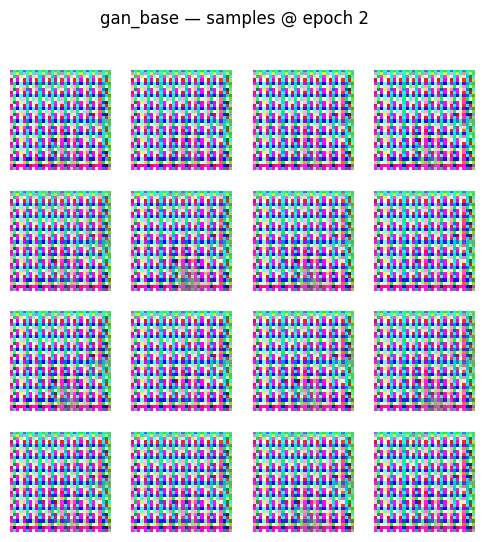

[gan_base] Epoch 3/10  D:0.9508  G:0.3866
[gan_base] Epoch 4/10  D:1.0844  G:0.3127


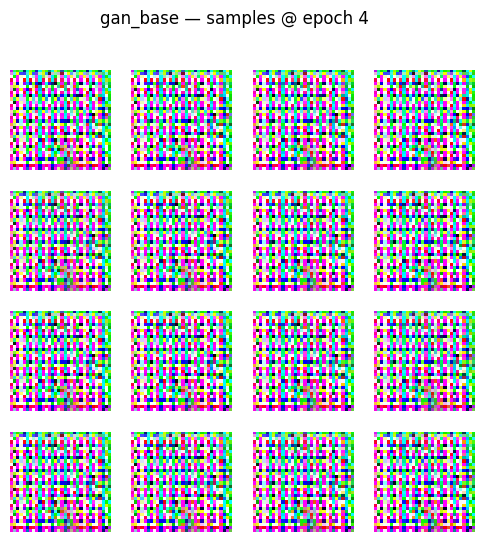

[gan_base] Epoch 5/10  D:1.2165  G:0.2593
[gan_base] Epoch 6/10  D:1.3311  G:0.2215


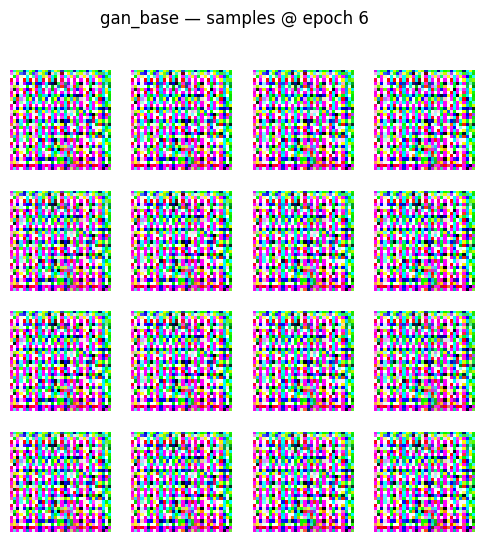

[gan_base] Epoch 7/10  D:1.4299  G:0.1934
[gan_base] Epoch 8/10  D:1.5177  G:0.1718


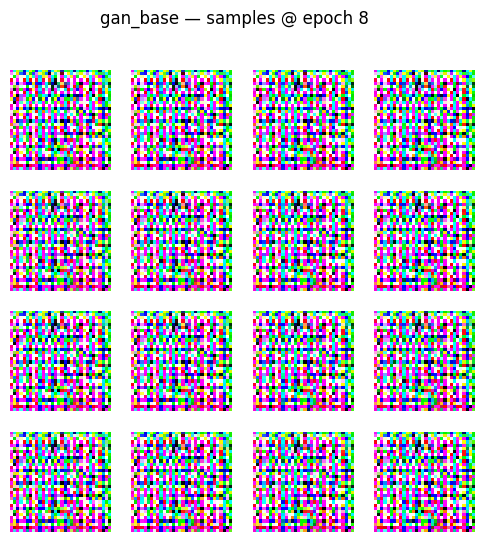

[gan_base] Epoch 9/10  D:1.5963  G:0.1546
[gan_base] Epoch 10/10  D:1.6665  G:0.1406


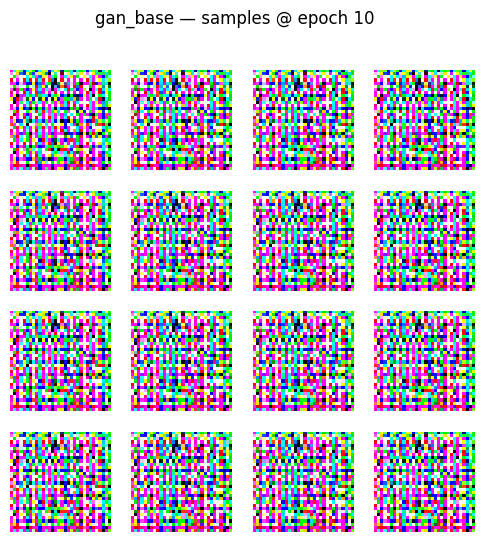

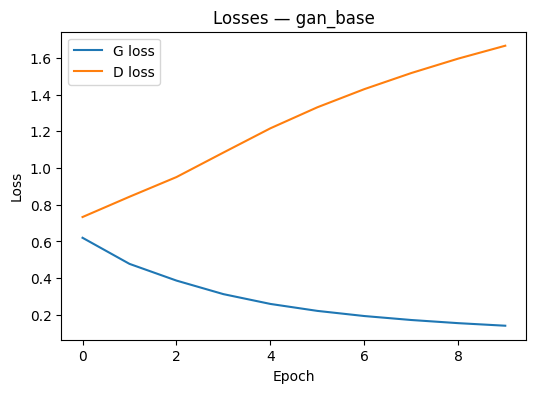

In [11]:
def plot_and_save_grid(imgs, title, path):
    n = imgs.shape[0]; cols = 4; rows = 4
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow((imgs[i]+1)/2); plt.axis('off')
    plt.suptitle(title); plt.savefig(path, dpi=200, bbox_inches='tight'); plt.show()

def train_gan(name, batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
              g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=1):
    G, D, GAN = build_gan(lr_g, lr_d, g_base, d_base, use_bn, deeper_d)
    steps_per_epoch = X_train_gan.shape[0] // batch_size
    fixed_noise = tf.random.normal([16, latent_dim])
    g_hist, d_hist = [], []

    for epoch in range(1, epochs+1):
        idx = np.random.permutation(X_train_gan.shape[0]); X_shuf = X_train_gan[idx]
        d_losses, g_losses = [], []

        for step in range(steps_per_epoch):
            real = X_shuf[step*batch_size:(step+1)*batch_size]
            z = tf.random.normal([batch_size, latent_dim]); fake = G.predict(z, verbose=0)
            y_real = np.ones((batch_size,1), np.float32); y_fake = np.zeros((batch_size,1), np.float32)
            d_loss = 0.5*(D.train_on_batch(real, y_real) + D.train_on_batch(fake, y_fake))
            g_loss = GAN.train_on_batch(tf.random.normal([batch_size, latent_dim]),
                                        np.ones((batch_size,1), np.float32))
            d_losses.append(float(d_loss)); g_losses.append(float(g_loss))

        d_hist.append(np.mean(d_losses)); g_hist.append(np.mean(g_losses))
        print(f"[{name}] Epoch {epoch}/{epochs}  D:{d_hist[-1]:.4f}  G:{g_hist[-1]:.4f}")

        if epoch % snapshot_every == 0:
            samples = G.predict(fixed_noise, verbose=0)
            plot_and_save_grid(samples, f"{name} — samples @ epoch {epoch}", f'{name}_epoch_{epoch}.png')

    plt.figure(figsize=(6,4))
    plt.plot(g_hist, label='G loss'); plt.plot(d_hist, label='D loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Losses — {name}')
    plt.legend(); plt.savefig(f'{name}_losses.png', dpi=200, bbox_inches='tight'); plt.show()
    return {"name": name, "g_hist": g_hist, "d_hist": d_hist}

# === Baseline quick run (fast) ===
baseline_hist = train_gan(name="gan_base", batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
                          g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=2)


#### 2.2 Hyperparameter Sensitivity — vary batch size / learning rate / capacity (Required)

[gan_b64_lr2e-4] Epoch 1/8  D:0.9045  G:0.4131


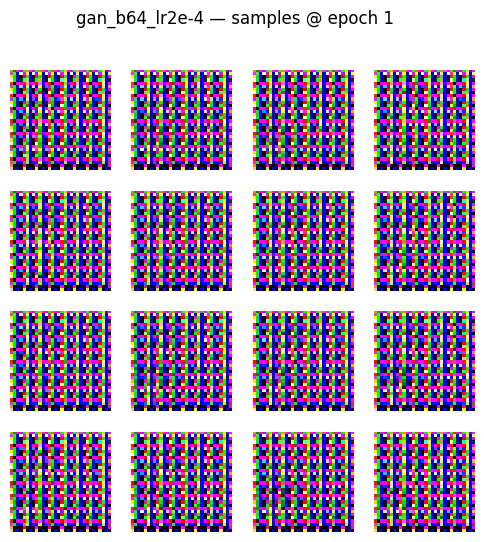

[gan_b64_lr2e-4] Epoch 2/8  D:1.2251  G:0.2199


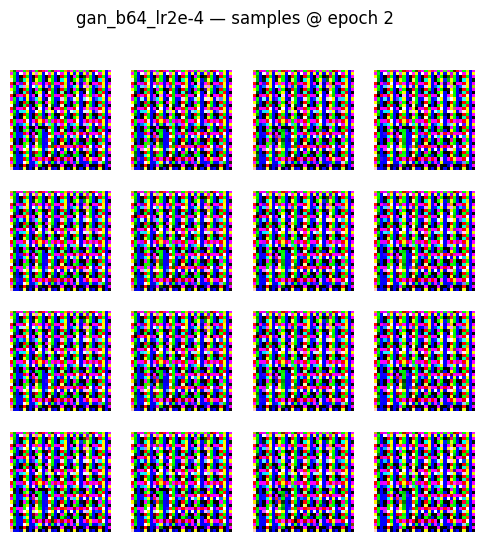

[gan_b64_lr2e-4] Epoch 3/8  D:1.4571  G:0.1524


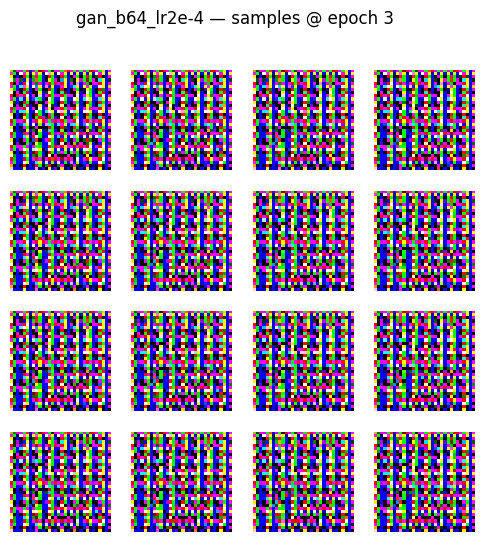

[gan_b64_lr2e-4] Epoch 4/8  D:1.6178  G:0.1184


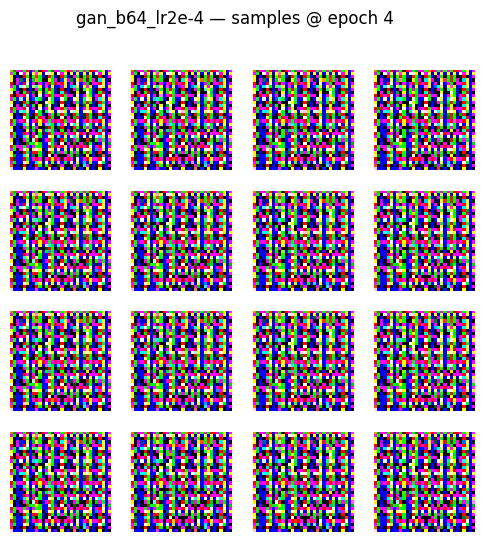

[gan_b64_lr2e-4] Epoch 5/8  D:1.7420  G:0.0976


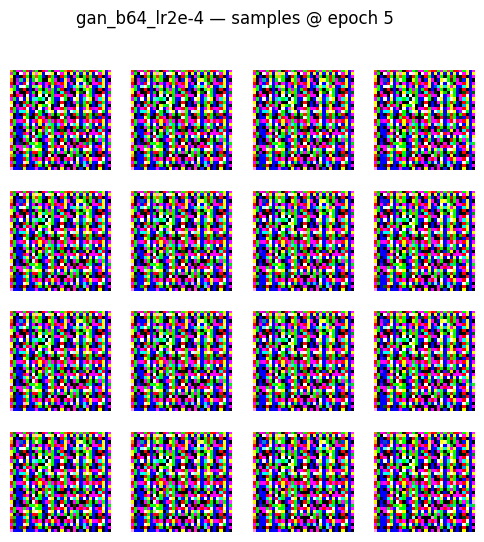

[gan_b64_lr2e-4] Epoch 6/8  D:1.8417  G:0.0834


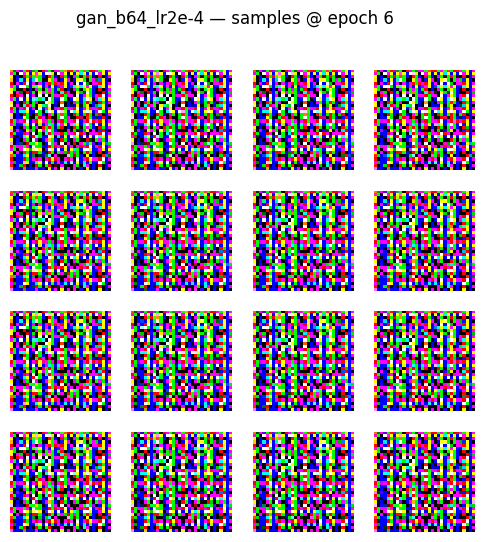

[gan_b64_lr2e-4] Epoch 7/8  D:1.9228  G:0.0731


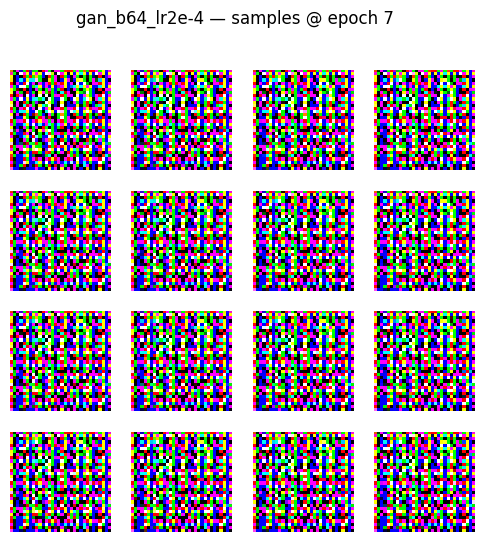

[gan_b64_lr2e-4] Epoch 8/8  D:1.9910  G:0.0653


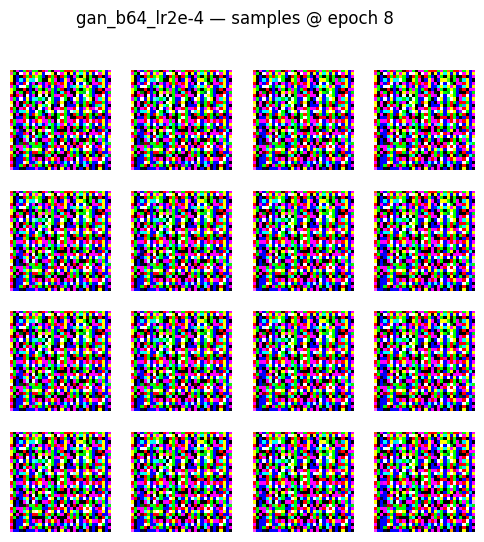

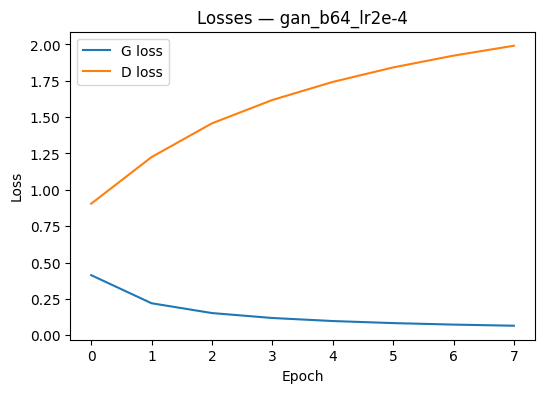

[gan_b256_lr5e-5] Epoch 1/8  D:0.6820  G:0.6773


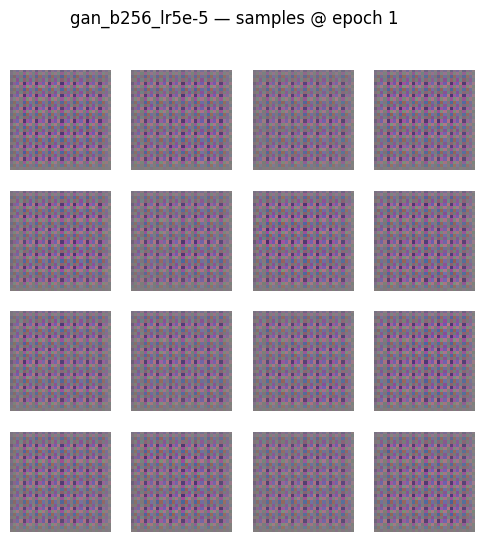

[gan_b256_lr5e-5] Epoch 2/8  D:0.7129  G:0.6244


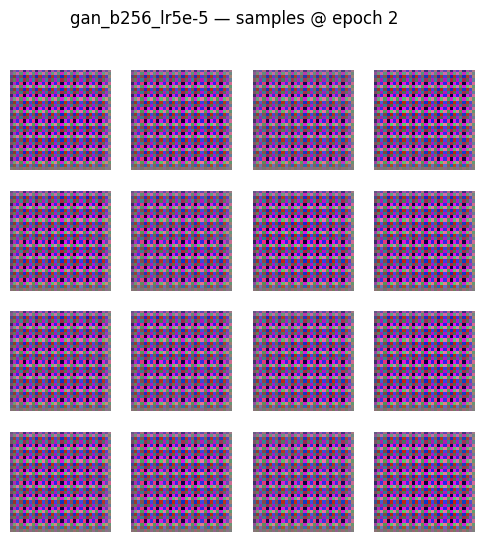

[gan_b256_lr5e-5] Epoch 3/8  D:0.7579  G:0.5605


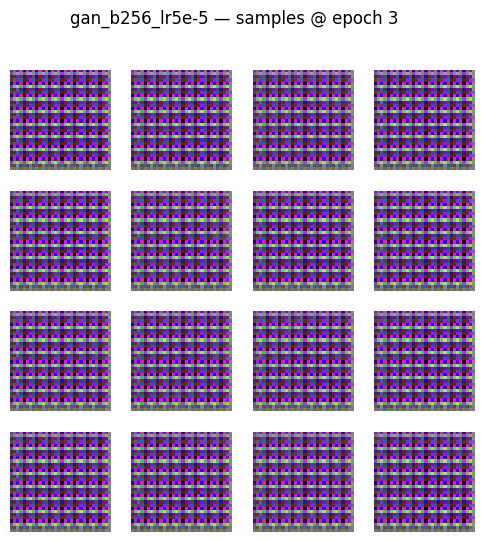

[gan_b256_lr5e-5] Epoch 4/8  D:0.7964  G:0.5123


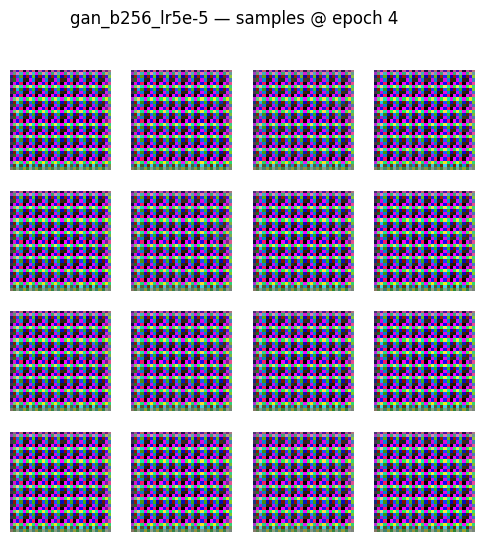

[gan_b256_lr5e-5] Epoch 5/8  D:0.8291  G:0.4756


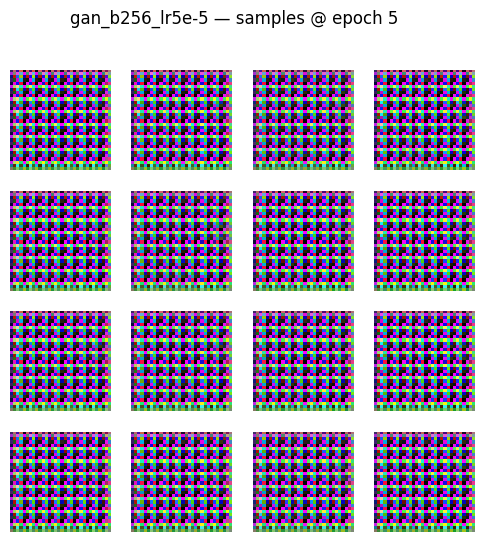

[gan_b256_lr5e-5] Epoch 6/8  D:0.8589  G:0.4454


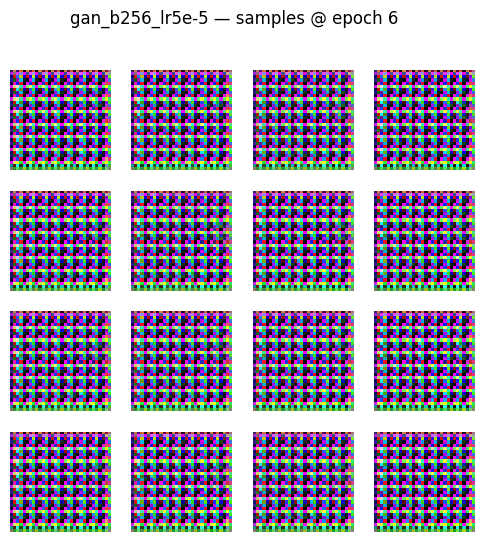

[gan_b256_lr5e-5] Epoch 7/8  D:0.8883  G:0.4188


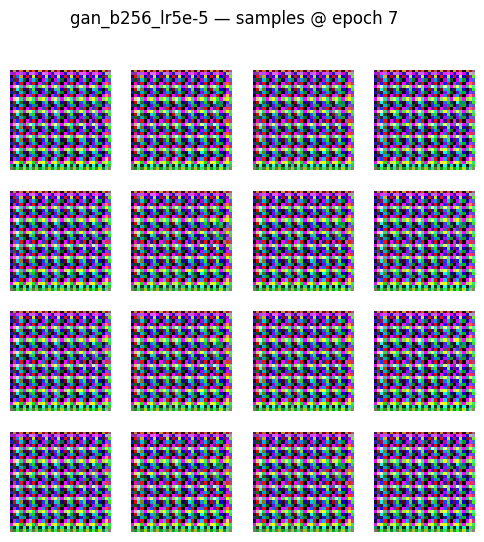

[gan_b256_lr5e-5] Epoch 8/8  D:0.9191  G:0.3940


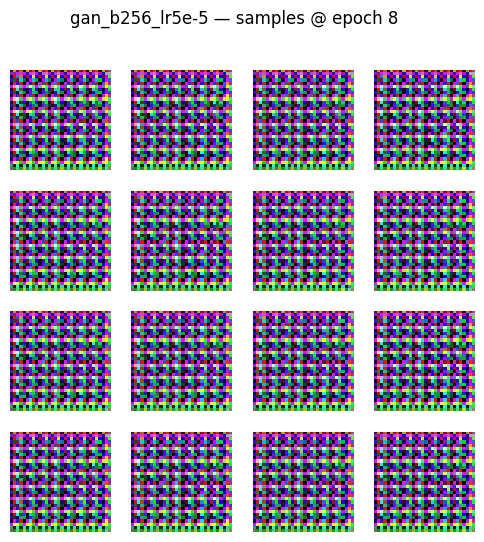

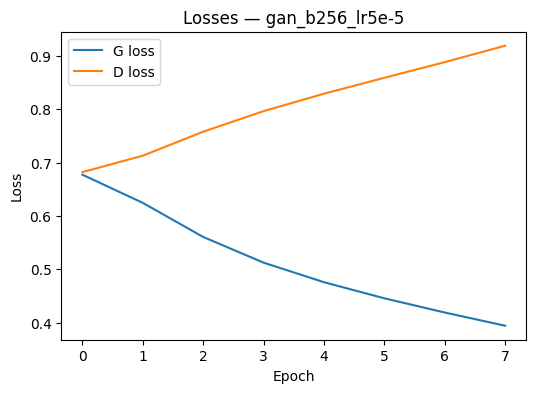

In [12]:
# Two tiny comparison runs (fast)
hist_b64  = train_gan(name="gan_b64_lr2e-4",  batch_size=64,  epochs=8, lr_g=2e-4, lr_d=2e-4,  g_base=256, d_base=64)
hist_b256 = train_gan(name="gan_b256_lr5e-5", batch_size=256, epochs=8, lr_g=5e-5, lr_d=5e-5, g_base=256, d_base=64)


#### 2.5 Mode Collapse Experiment — intentionally unstable config (Required)

[gan_collapse] Epoch 1/6  D:1.3989  G:0.1907


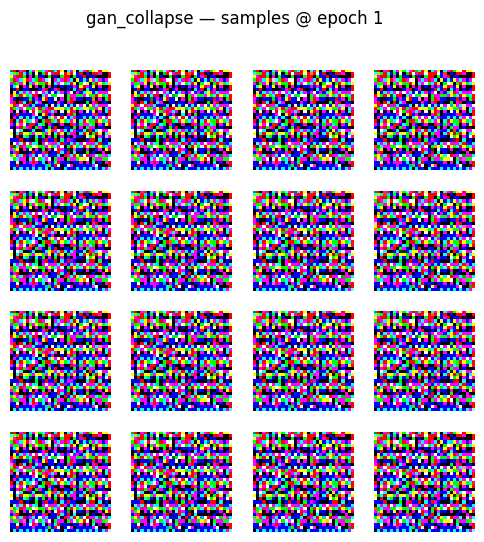

[gan_collapse] Epoch 2/6  D:2.0090  G:0.0672


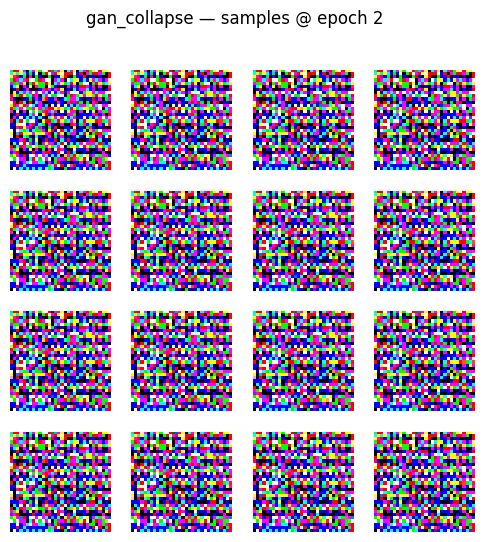

[gan_collapse] Epoch 3/6  D:2.2552  G:0.0440


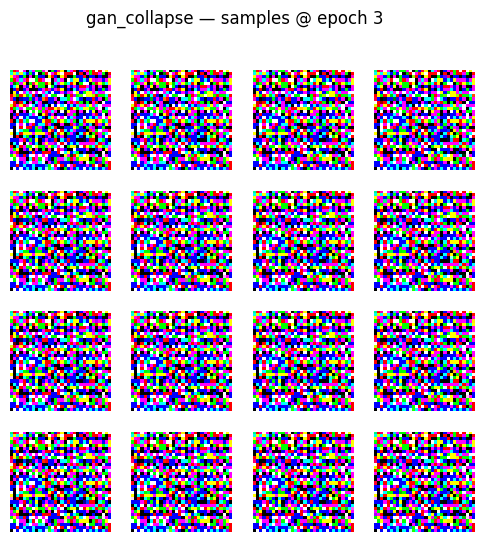

[gan_collapse] Epoch 4/6  D:2.3900  G:0.0338


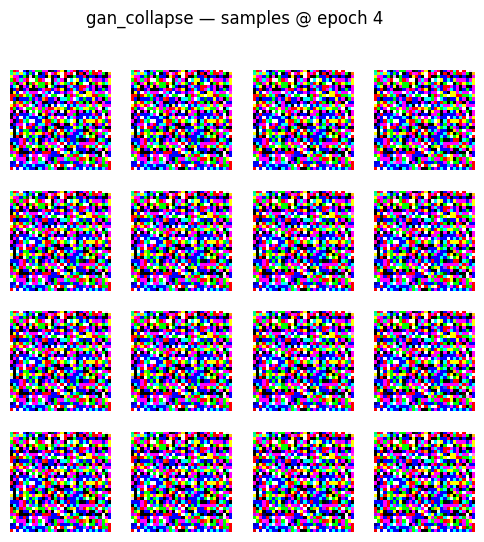

[gan_collapse] Epoch 5/6  D:2.4820  G:0.0279


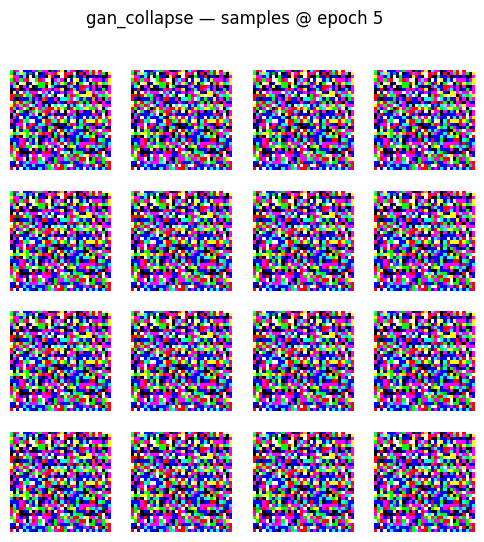

[gan_collapse] Epoch 6/6  D:2.5541  G:0.0239


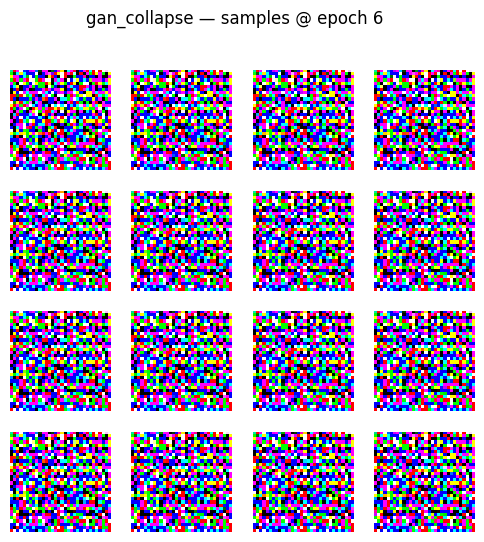

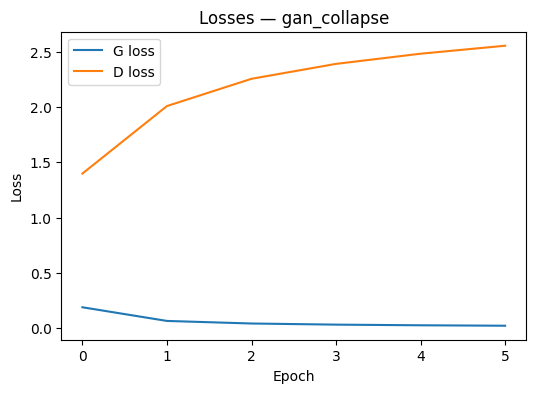

In [13]:
# Very unstable: tiny batch, G lr >> D lr
hist_collapse = train_gan(name="gan_collapse", batch_size=32, epochs=6, lr_g=2e-3, lr_d=5e-5,
                          g_base=256, d_base=64, use_bn=False, deeper_d=False)
# In your report: note repeated/near-identical samples & odd loss behavior.


#### 2.6 Modify GAN Architecture — add BatchNorm / deeper D (Required)

[gan_arch_v2] Epoch 1/8  D:0.7098  G:0.5614


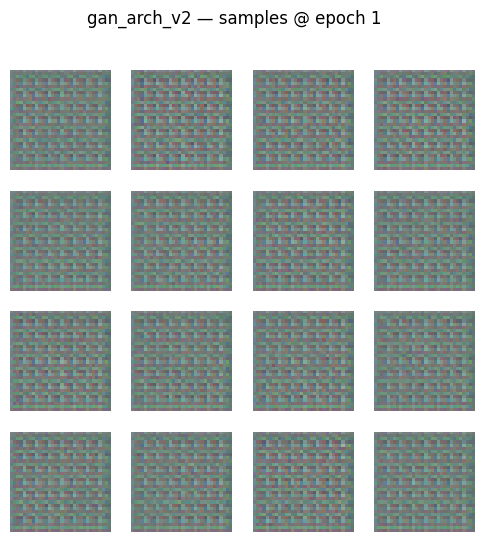

[gan_arch_v2] Epoch 2/8  D:0.7172  G:0.4653


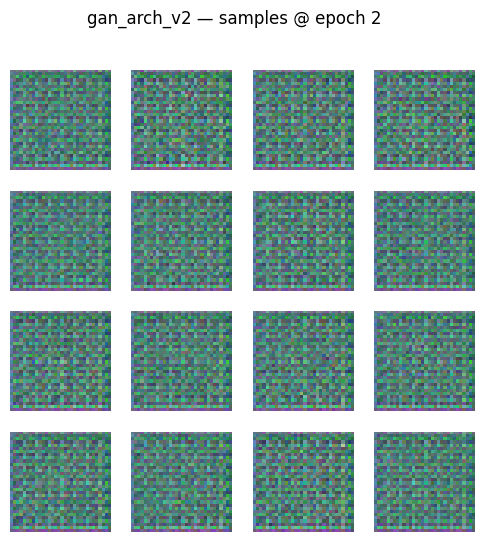

[gan_arch_v2] Epoch 3/8  D:0.7270  G:0.4086


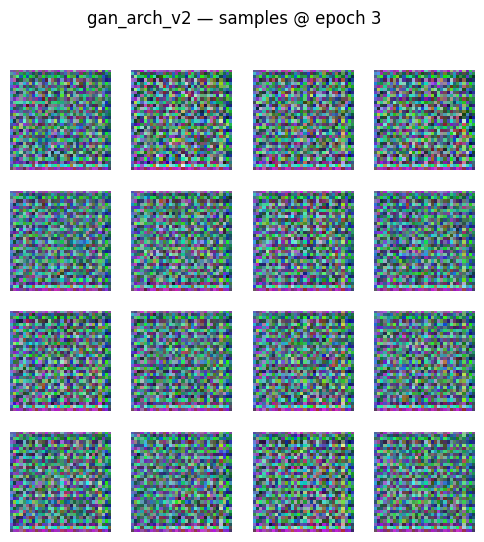

[gan_arch_v2] Epoch 4/8  D:0.7570  G:0.3637


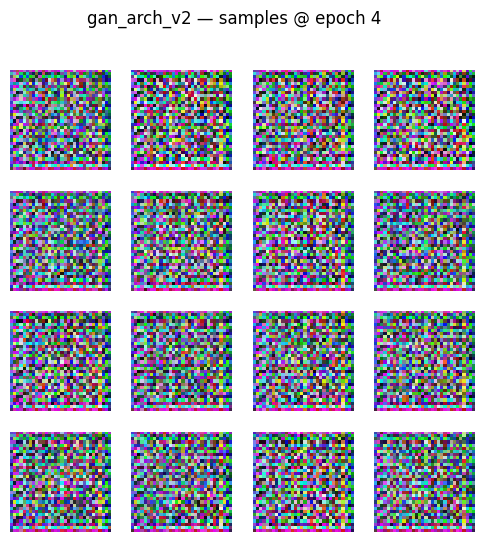

[gan_arch_v2] Epoch 5/8  D:0.8129  G:0.3283


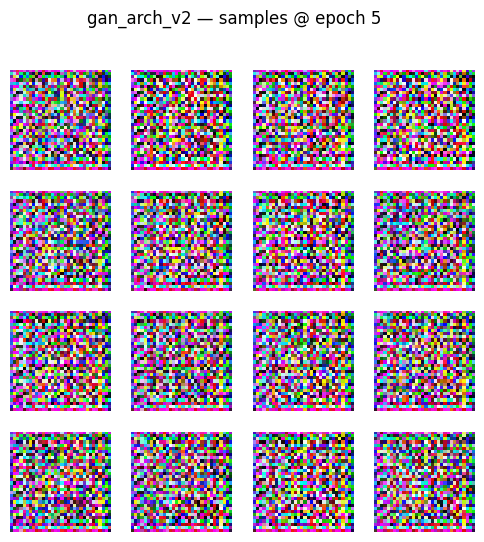

[gan_arch_v2] Epoch 6/8  D:0.8817  G:0.2998


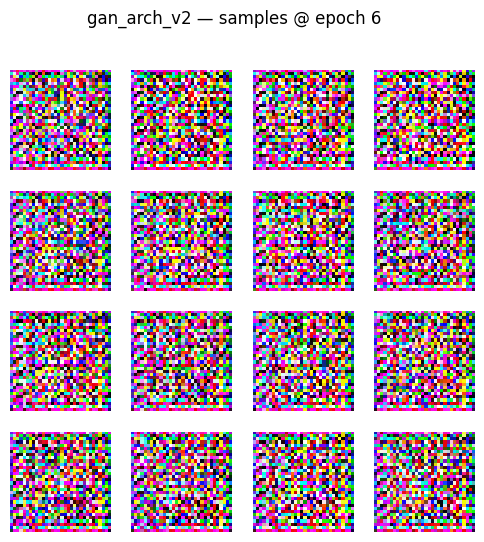

[gan_arch_v2] Epoch 7/8  D:0.9488  G:0.2765


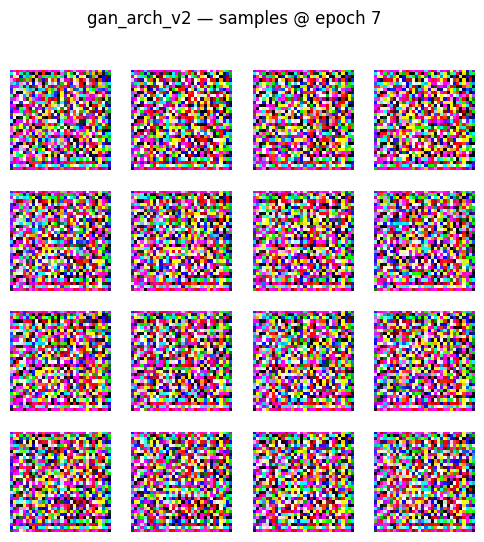

[gan_arch_v2] Epoch 8/8  D:1.0088  G:0.2570


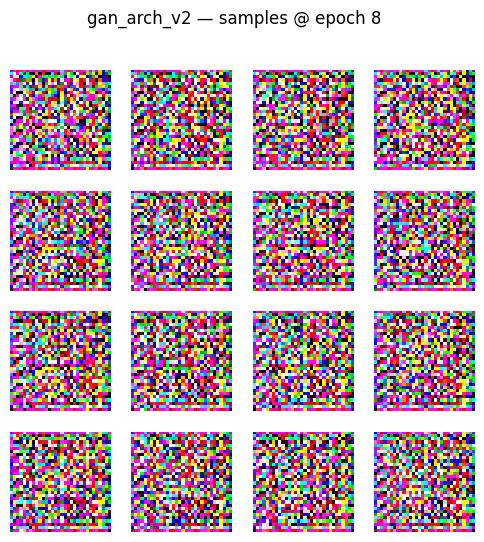

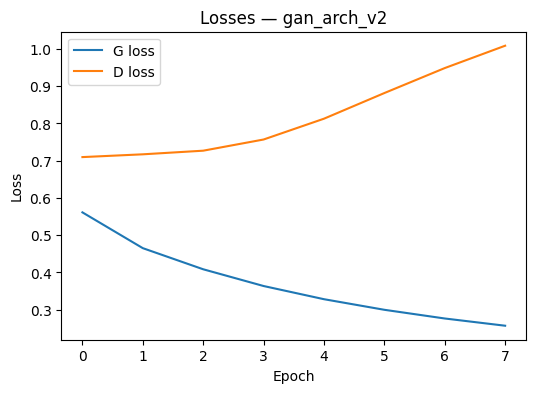

In [14]:
# Architecture variant: BatchNorm in G + deeper D for capacity/regularization
hist_arch = train_gan(name="gan_arch_v2", batch_size=128, epochs=8, lr_g=1e-4, lr_d=1e-4,
                      g_base=256, d_base=64, use_bn=True, deeper_d=True)
# In your report: compare visuals and losses vs baseline.


In [15]:
def interpolate_latent(G, z_a=None, z_b=None, steps=10, save_path="interpolation.png"):
    if z_a is None:
        z_a = tf.random.normal([1, latent_dim])
    if z_b is None:
        z_b = tf.random.normal([1, latent_dim])

    # Linearly interpolate
    ratios = np.linspace(0, 1, steps)
    z_interp = np.array([(1-r)*z_a + r*z_b for r in ratios])
    
    # Generate images
    imgs = G.predict(z_interp, verbose=0)
    
    # Plot in a strip
    plt.figure(figsize=(2*steps, 2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow((imgs[i]+1)/2)   # scale from [-1,1] to [0,1]
        plt.axis('off')
    plt.suptitle("Latent Interpolation")
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


In [16]:
interpolate_latent(G, steps=8)


NameError: name 'G' is not defined

[gan_base] Epoch 1/10  D:0.7187  G:0.4681
[gan_base] Epoch 2/10  D:0.6339  G:0.5575


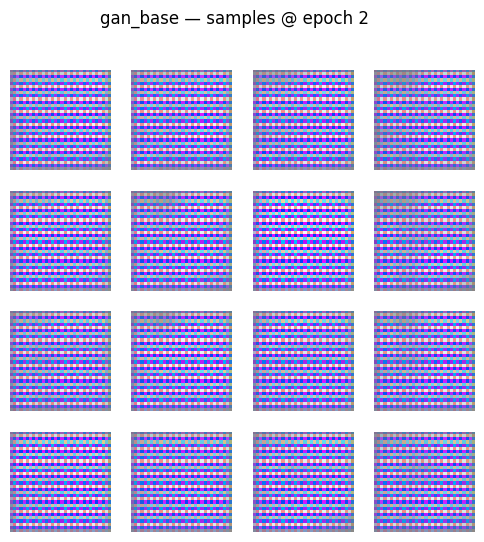

[gan_base] Epoch 3/10  D:0.6597  G:0.5783
[gan_base] Epoch 4/10  D:0.6041  G:0.6658


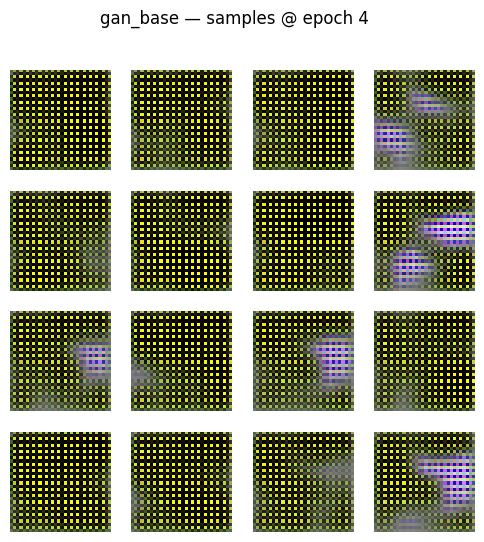

[gan_base] Epoch 5/10  D:0.5810  G:0.6994
[gan_base] Epoch 6/10  D:0.5661  G:0.7236


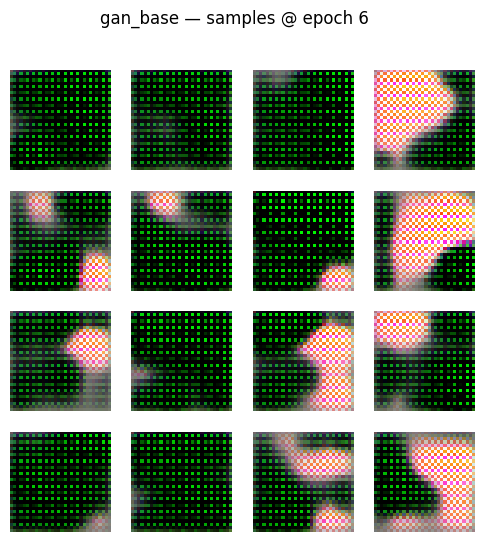

[gan_base] Epoch 7/10  D:0.5618  G:0.7329
[gan_base] Epoch 8/10  D:0.5624  G:0.7316


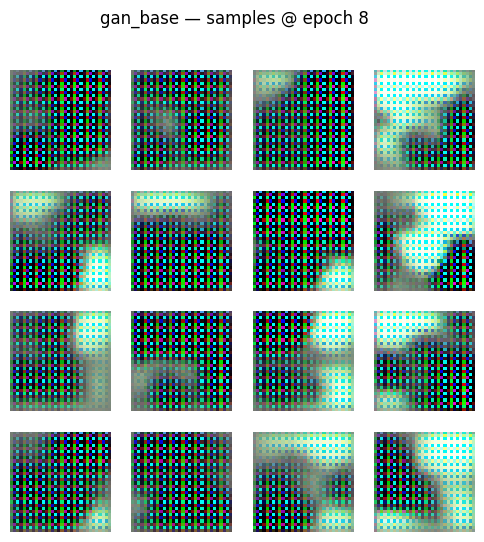

[gan_base] Epoch 9/10  D:0.5616  G:0.7305
[gan_base] Epoch 10/10  D:0.5750  G:0.7148


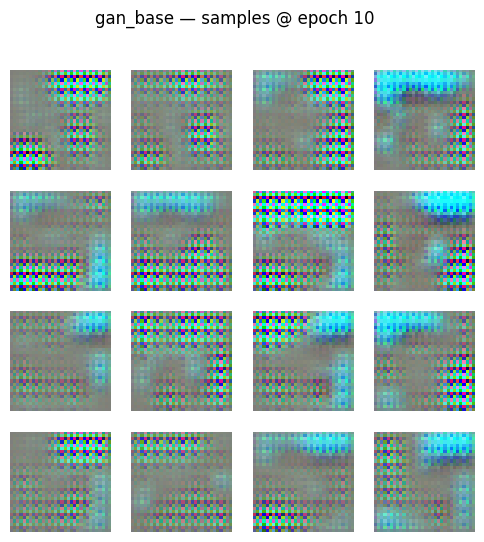

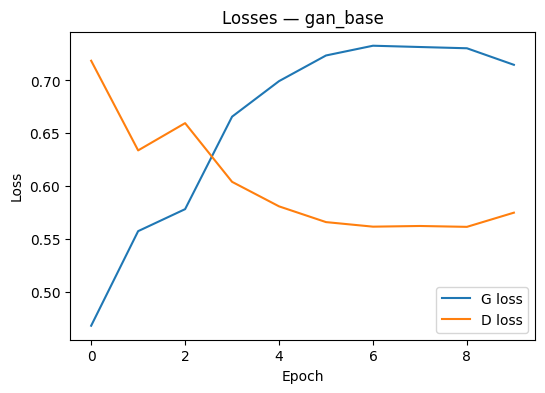

[gan_b64_lr2e-4] Epoch 1/8  D:0.6451  G:0.6509


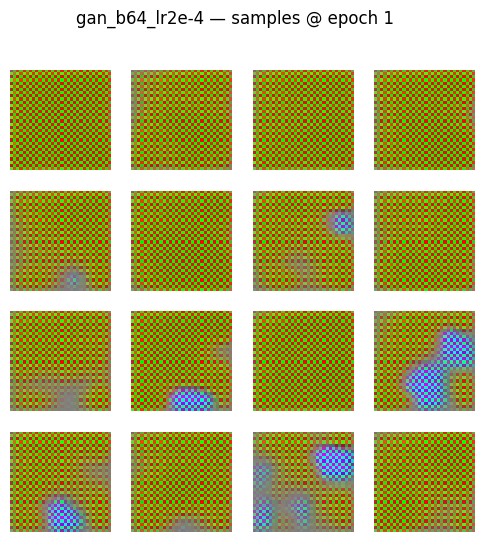

[gan_b64_lr2e-4] Epoch 2/8  D:0.5029  G:0.9541


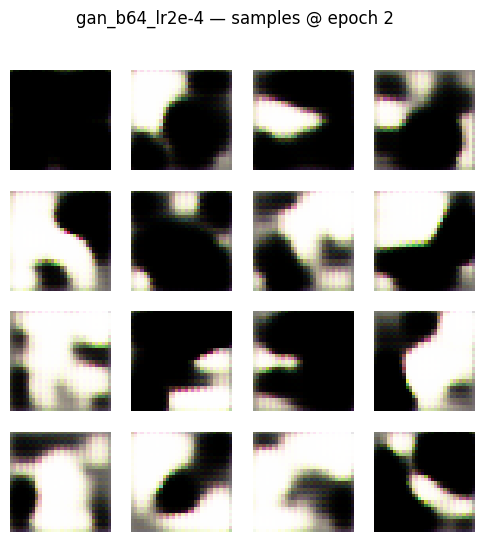

[gan_b64_lr2e-4] Epoch 3/8  D:0.5165  G:1.0135


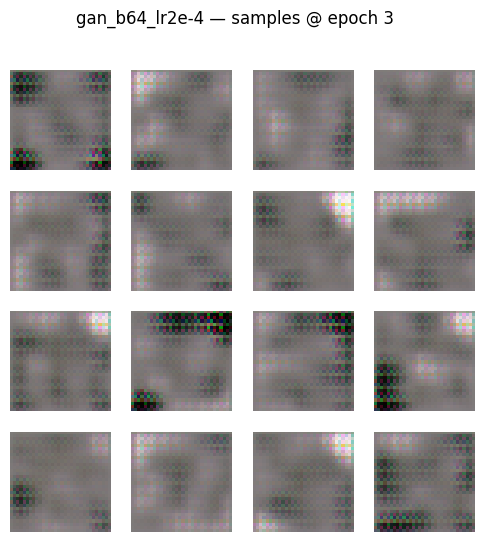

[gan_b64_lr2e-4] Epoch 4/8  D:0.5605  G:0.8920


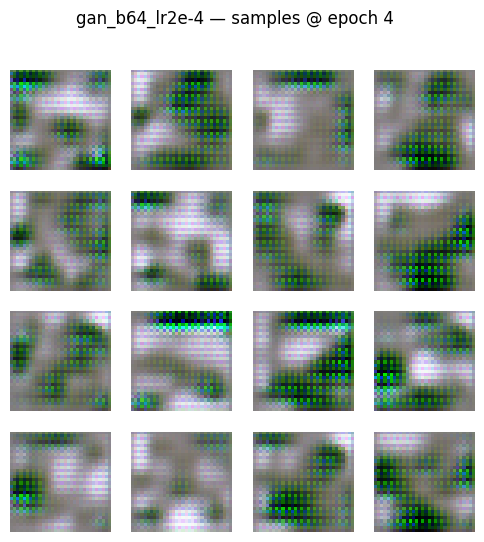

[gan_b64_lr2e-4] Epoch 5/8  D:0.5837  G:0.8180


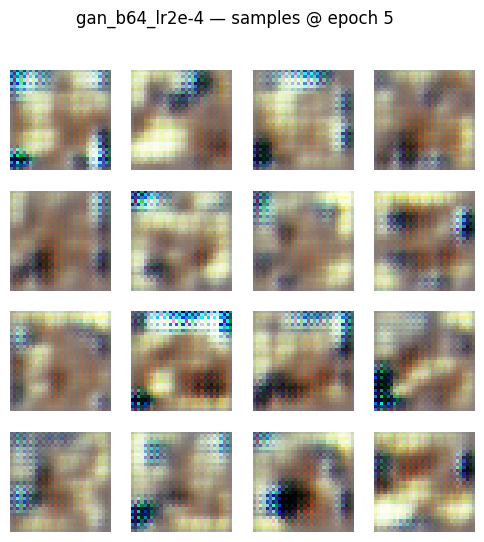

[gan_b64_lr2e-4] Epoch 6/8  D:0.6047  G:0.7805


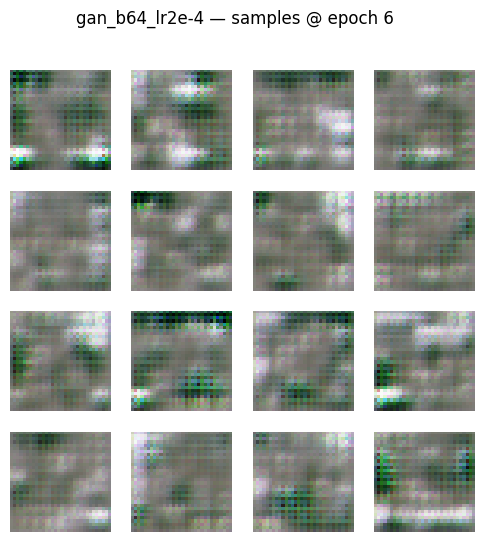

[gan_b64_lr2e-4] Epoch 7/8  D:0.6201  G:0.7595


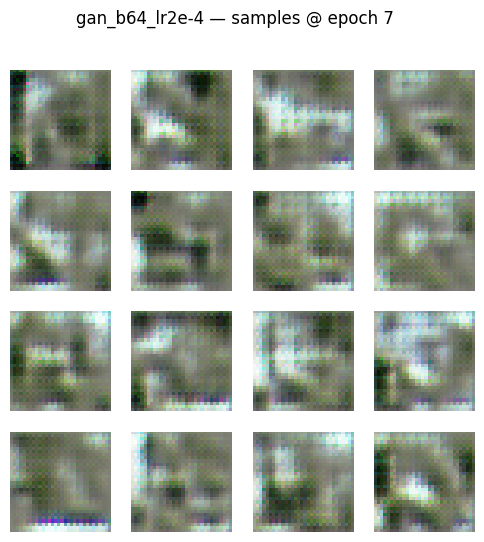

[gan_b64_lr2e-4] Epoch 8/8  D:0.6364  G:0.7588


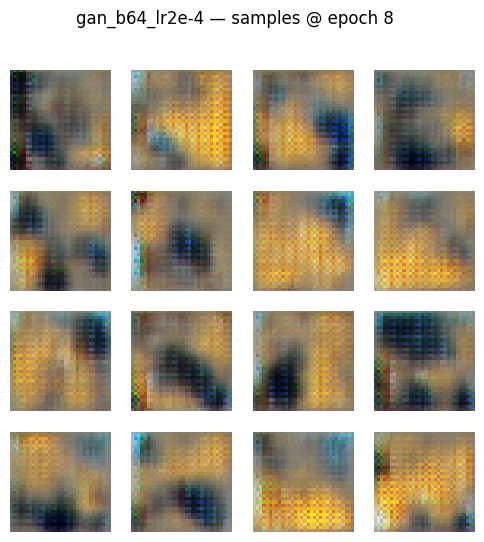

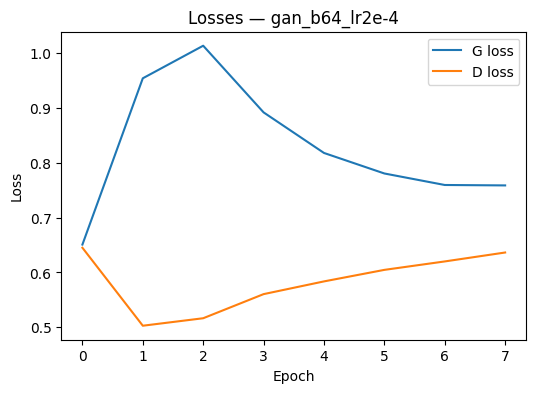

[gan_b256_lr5e-5] Epoch 1/8  D:0.6528  G:0.6217


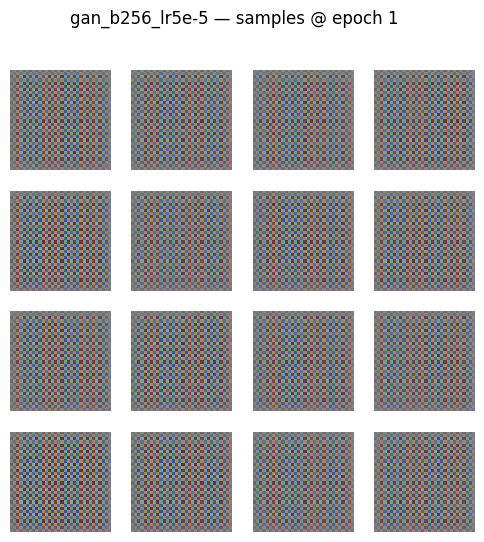

[gan_b256_lr5e-5] Epoch 2/8  D:0.7369  G:0.4270


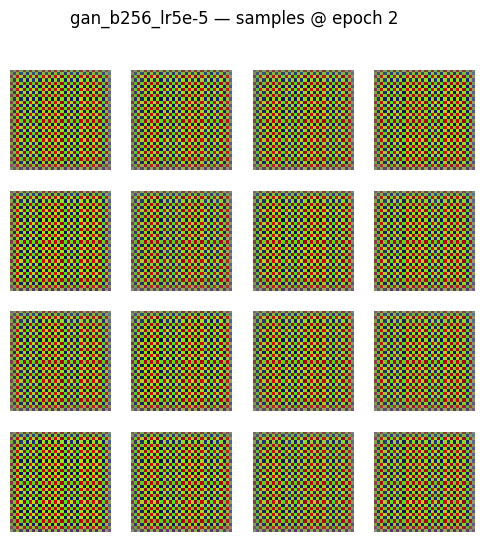

[gan_b256_lr5e-5] Epoch 3/8  D:0.7765  G:0.3666


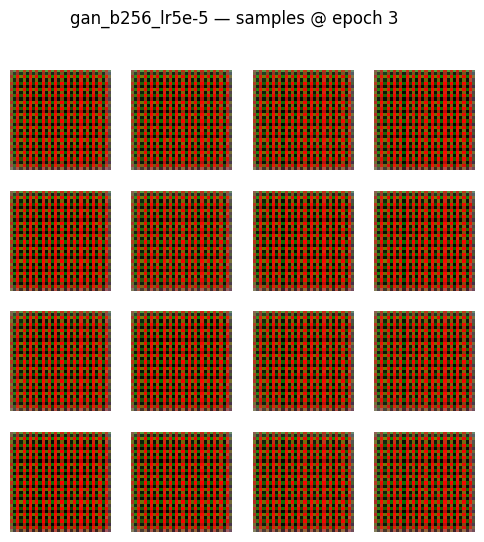

[gan_b256_lr5e-5] Epoch 4/8  D:0.7456  G:0.3813


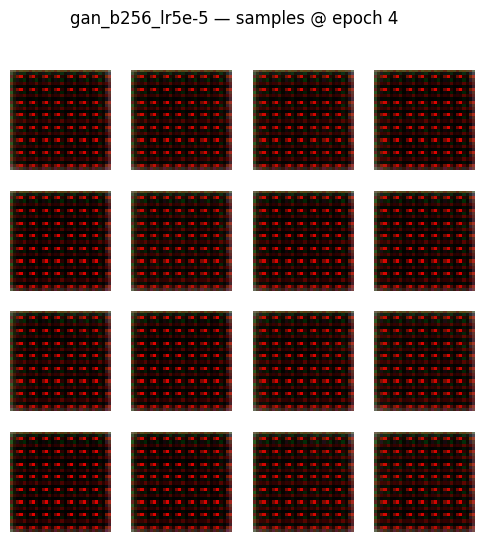

[gan_b256_lr5e-5] Epoch 5/8  D:0.7246  G:0.3989


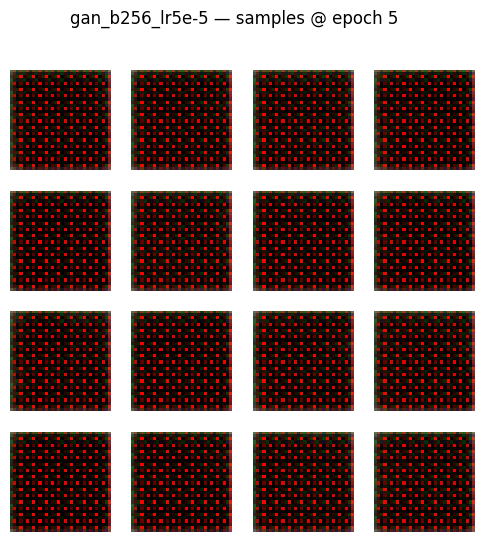

[gan_b256_lr5e-5] Epoch 6/8  D:0.6991  G:0.4231


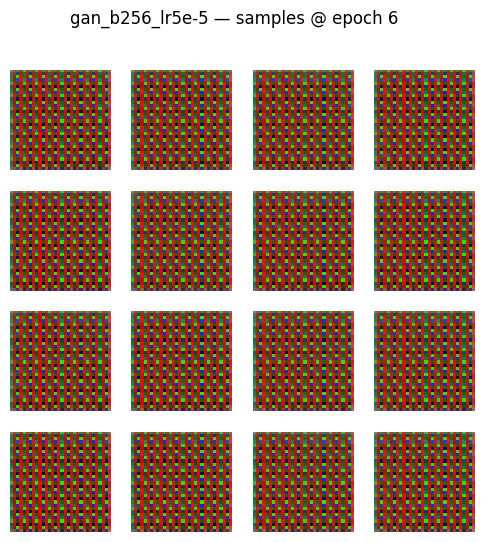

[gan_b256_lr5e-5] Epoch 7/8  D:0.7057  G:0.4195


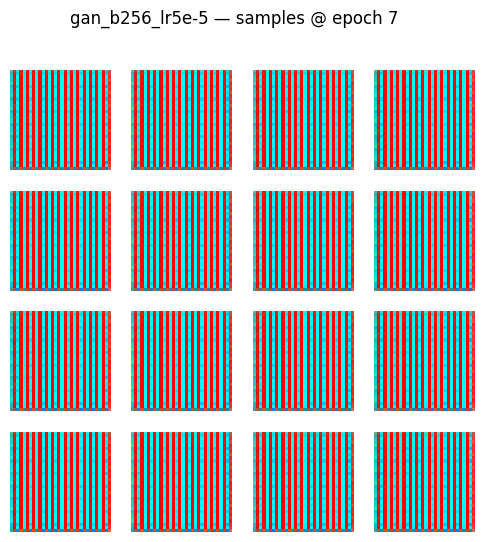

[gan_b256_lr5e-5] Epoch 8/8  D:0.7129  G:0.4250


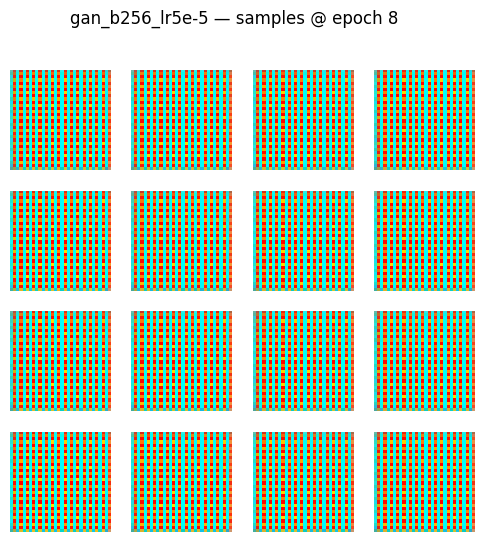

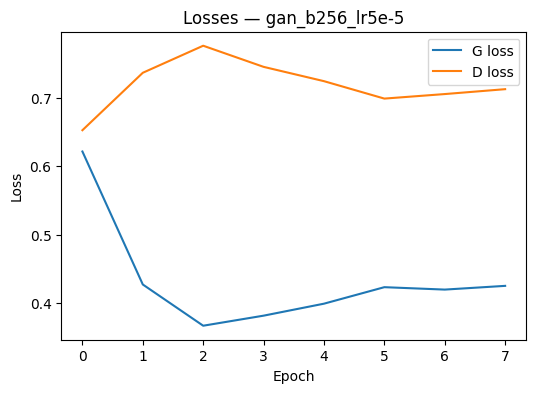

[gan_collapse] Epoch 1/6  D:31.1994  G:0.0222


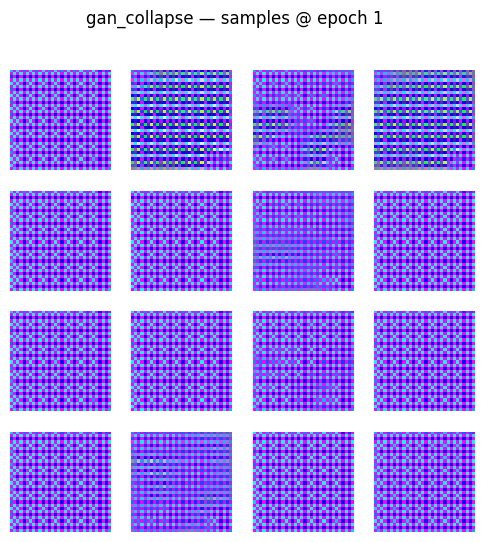

[gan_collapse] Epoch 2/6  D:20.6633  G:0.0027


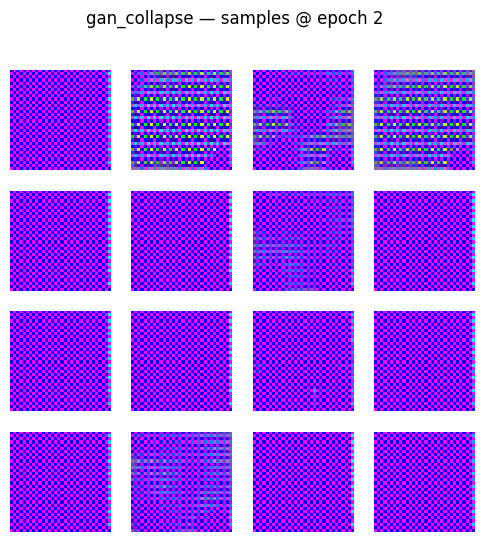

[gan_collapse] Epoch 3/6  D:110.7602  G:0.0017


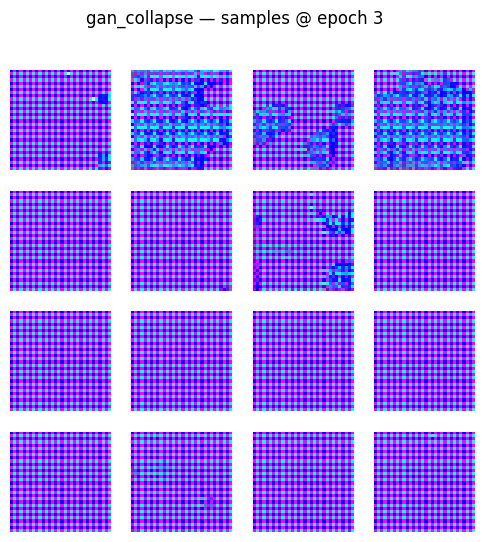

[gan_collapse] Epoch 4/6  D:205.1873  G:0.0013


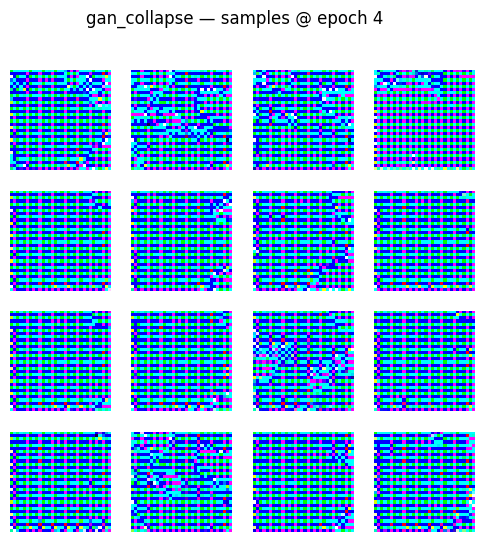

[gan_collapse] Epoch 5/6  D:210.0325  G:0.0010


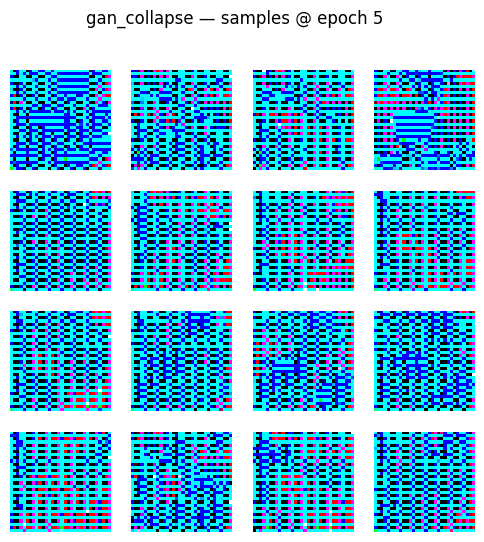

[gan_collapse] Epoch 6/6  D:196.8208  G:0.0009


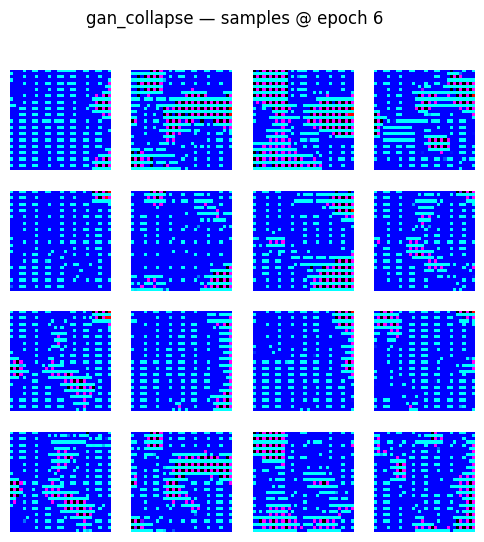

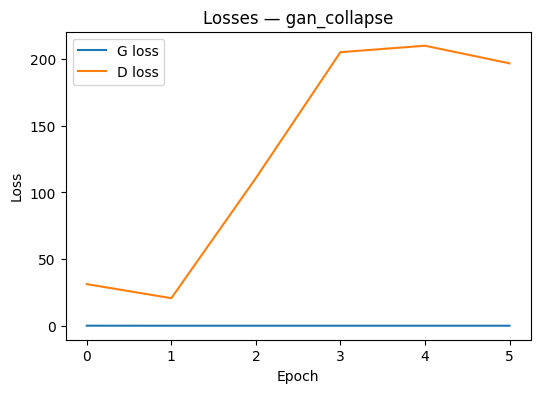

In [17]:
# ==== (keep your existing imports / data prep) ====
# assumes: latent_dim, X_train_gan in [-1, 1], shape (N, 32, 32, 3)

def make_generator(g_base=256, use_bn=False):
    G = tf.keras.Sequential(name=f"Generator_g{g_base}{'_bn' if use_bn else ''}")
    G.add(tf.keras.layers.Input(shape=(latent_dim,)))
    G.add(tf.keras.layers.Dense(8*8*g_base))
    if use_bn: G.add(tf.keras.layers.BatchNormalization())
    G.add(tf.keras.layers.LeakyReLU(0.2))
    G.add(tf.keras.layers.Reshape((8,8,g_base)))
    G.add(tf.keras.layers.Conv2DTranspose(g_base//2, 4, strides=2, padding='same'))
    if use_bn: G.add(tf.keras.layers.BatchNormalization())
    G.add(tf.keras.layers.LeakyReLU(0.2))
    G.add(tf.keras.layers.Conv2DTranspose(g_base//4, 4, strides=2, padding='same'))
    if use_bn: G.add(tf.keras.layers.BatchNormalization())
    G.add(tf.keras.layers.LeakyReLU(0.2))
    G.add(tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh'))
    return G

def make_discriminator(d_base=64, drop=0.25, deeper=False):
    D = tf.keras.Sequential(name=f"Discriminator_d{d_base}{'_deep' if deeper else ''}")
    D.add(tf.keras.layers.Input(shape=(32,32,3)))
    D.add(tf.keras.layers.Conv2D(d_base,   3, strides=2, padding='same')); D.add(tf.keras.layers.LeakyReLU(0.2)); D.add(tf.keras.layers.Dropout(drop))
    D.add(tf.keras.layers.Conv2D(d_base*2, 3, strides=2, padding='same')); D.add(tf.keras.layers.LeakyReLU(0.2)); D.add(tf.keras.layers.Dropout(drop))
    if deeper:
        D.add(tf.keras.layers.Conv2D(d_base*4, 3, strides=2, padding='same')); D.add(tf.keras.layers.LeakyReLU(0.2)); D.add(tf.keras.layers.Dropout(drop))
    D.add(tf.keras.layers.Flatten())
    D.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return D

def build_gan(lr_g=1e-4, lr_d=1e-4, g_base=256, d_base=64, use_bn=False, deeper_d=False):
    G = make_generator(g_base=g_base, use_bn=use_bn)
    D = make_discriminator(d_base=d_base, deeper=deeper_d)
    D.compile(optimizer=tf.keras.optimizers.Adam(lr_d), loss='binary_crossentropy')

    z_in = tf.keras.layers.Input(shape=(latent_dim,))
    fake = G(z_in)
    D.trainable = False
    valid = D(fake)
    GAN = tf.keras.Model(z_in, valid, name="GAN")
    GAN.compile(optimizer=tf.keras.optimizers.Adam(lr_g), loss='binary_crossentropy')
    D.trainable = True
    return G, D, GAN

def plot_and_save_grid(imgs, title, path):
    n = imgs.shape[0]; cols = 4; rows = (n + cols - 1) // cols
    plt.figure(figsize=(6, 1.5*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow((imgs[i]+1)/2); plt.axis('off')
    plt.suptitle(title); plt.savefig(path, dpi=200, bbox_inches='tight'); plt.show()

def train_gan(name, batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
              g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=1):
    G, D, GAN = build_gan(lr_g, lr_d, g_base, d_base, use_bn, deeper_d)
    steps_per_epoch = X_train_gan.shape[0] // batch_size
    fixed_noise = tf.random.normal([16, latent_dim])
    g_hist, d_hist = [], []

    for epoch in range(1, epochs+1):
        idx = np.random.permutation(X_train_gan.shape[0]); X_shuf = X_train_gan[idx]
        d_losses, g_losses = [], []

        for step in range(steps_per_epoch):
            real = X_shuf[step*batch_size:(step+1)*batch_size]
            z = tf.random.normal([batch_size, latent_dim]); fake = G.predict(z, verbose=0)
            y_real = np.ones((batch_size,1), np.float32); y_fake = np.zeros((batch_size,1), np.float32)
            d_loss = 0.5*(D.train_on_batch(real, y_real) + D.train_on_batch(fake, y_fake))
            g_loss = GAN.train_on_batch(tf.random.normal([batch_size, latent_dim]),
                                        np.ones((batch_size,1), np.float32))
            d_losses.append(float(d_loss)); g_losses.append(float(g_loss))

        d_hist.append(np.mean(d_losses)); g_hist.append(np.mean(g_losses))
        print(f"[{name}] Epoch {epoch}/{epochs}  D:{d_hist[-1]:.4f}  G:{g_hist[-1]:.4f}")

        if epoch % snapshot_every == 0:
            samples = G.predict(fixed_noise, verbose=0)
            plot_and_save_grid(samples, f"{name} — samples @ epoch {epoch}", f'{name}_epoch_{epoch}.png')

    # loss curves
    plt.figure(figsize=(6,4))
    plt.plot(g_hist, label='G loss'); plt.plot(d_hist, label='D loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Losses — {name}')
    plt.legend(); plt.savefig(f'{name}_losses.png', dpi=200, bbox_inches='tight'); plt.show()

    # ⬅ return models too (so you can use G later)
    return {"name": name, "g_hist": g_hist, "d_hist": d_hist, "G": G, "D": D, "GAN": GAN}

# === examples (same as you had) ===
baseline = train_gan(name="gan_base", batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
                     g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=2)

hist_b64  = train_gan(name="gan_b64_lr2e-4",  batch_size=64,  epochs=8, lr_g=2e-4, lr_d=2e-4,  g_base=256, d_base=64)
hist_b256 = train_gan(name="gan_b256_lr5e-5", batch_size=256, epochs=8, lr_g=5e-5, lr_d=5e-5, g_base=256, d_base=64)

collapse  = train_gan(name="gan_collapse", batch_size=32, epochs=6, lr_g=2e-3, lr_d=5e-5,
                      g_base=256, d_base=64, use_bn=False, deeper_d=False)


#### Latent interpolation strip (Part 3.4)

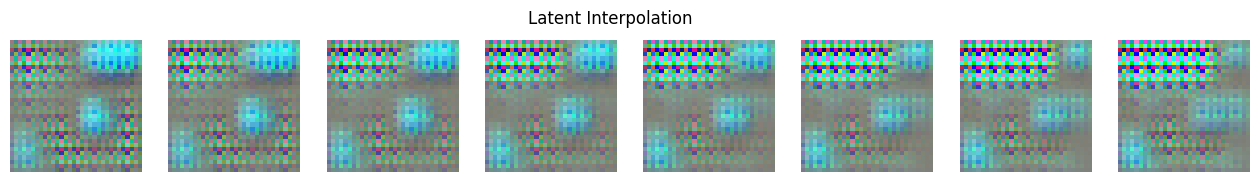

In [18]:
def interpolate_latent(G, steps=10, z_a=None, z_b=None, save_path="interpolation.png"):
    """Create a z_a→z_b strip using the trained generator G."""
    if z_a is None:
        z_a = tf.random.normal([1, latent_dim])
    if z_b is None:
        z_b = tf.random.normal([1, latent_dim])

    ratios = np.linspace(0, 1, steps, dtype=np.float32)
    z_interp = np.concatenate([(1-r)*z_a + r*z_b for r in ratios], axis=0)

    imgs = G.predict(z_interp, verbose=0)

    plt.figure(figsize=(2*steps, 2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow((imgs[i]+1)/2)
        plt.axis('off')
    plt.suptitle("Latent Interpolation")
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# --- usage (use the trained generator from your baseline dict) ---
interpolate_latent(baseline["G"], steps=8, save_path="gan_base_interp.png")


#### Synthetic vs Real vs Hybrid for LR (Part 3.3)

In [21]:
# === Fixed "Domain Gap" experiment: Real vs Synthetic vs Hybrid (Logistic Regression) ===
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ---------- helpers ----------
def sample_synthetic(G, n=5000, latent_dim=128):
    """Sample n synthetic images from trained generator G, return float32 in [0,1]."""
    z = tf.random.normal([n, latent_dim])
    imgs = G.predict(z, verbose=0)   # expected in [-1, 1]
    # normalize to [0,1]
    imgs = (imgs + 1.0) / 2.0
    imgs = np.clip(imgs, 0.0, 1.0).astype(np.float32)
    return imgs

def flatten_images(imgs):
    return imgs.reshape((imgs.shape[0], -1))

def lr_pipeline(pca_components=256, C=1.0, penalty="l2", max_iter=2000):
    """Mirror your Part 1 pipeline: Standardize -> PCA -> Multinomial LR."""
    return Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("pca", PCA(n_components=pca_components, whiten=True, random_state=42)),
        ("lr", LogisticRegression(
            C=C,
            penalty=penalty,
            solver="saga" if penalty=="l1" else "lbfgs",
            max_iter=max_iter,
            multi_class="multinomial",
            n_jobs=-1
        ))
    ])

def _to_01(x):
    """Normalize images to [0,1] from [0,255] or [-1,1] or leave if already [0,1]."""
    x = x.astype(np.float32)
    xmin, xmax = float(x.min()), float(x.max())
    if xmax > 1.5:      # likely [0,255]
        x = x / 255.0
    elif xmin < -0.5:   # likely [-1,1]
        x = (x + 1.0) / 2.0
    return np.clip(x, 0.0, 1.0)

def _find_real_data_from_globals(g):
    """
    Try to locate real train/test arrays & labels from common names used in Part 1.
    Returns: (X_train_real, y_train, X_test_real, y_test)
    """
    # candidates in priority order (add your names here if different)
    X_train_names = ["X_train_lr_images", "X_train_lr", "X_train"]
    X_test_names  = ["X_test_lr_images",  "X_test_lr",  "X_test"]
    y_train_names = ["y_train"]
    y_test_names  = ["y_test"]

    X_train_real = next((g[name] for name in X_train_names if name in g), None)
    X_test_real  = next((g[name] for name in X_test_names  if name in g), None)
    y_train      = next((g[name] for name in y_train_names if name in g), None)
    y_test       = next((g[name] for name in y_test_names  if name in g), None)

    if X_train_real is None or X_test_real is None or y_train is None or y_test is None:
        missing = []
        if X_train_real is None: missing.append("X_train_*")
        if X_test_real  is None: missing.append("X_test_*")
        if y_train      is None: missing.append("y_train")
        if y_test       is None: missing.append("y_test")
        raise NameError(
            f"Could not find required arrays in notebook globals: {', '.join(missing)}.\n"
            "Set them to your Part 1 arrays, or add your variable names to the candidate lists."
        )
    # ensure label shape is (N,)
    y_train = np.asarray(y_train).reshape(-1)
    y_test  = np.asarray(y_test).reshape(-1)
    # normalize images to [0,1]
    X_train_real = _to_01(np.asarray(X_train_real))
    X_test_real  = _to_01(np.asarray(X_test_real))
    return X_train_real, y_train, X_test_real, y_test

def eval_real_vs_synth_vs_hybrid(G, 
                                 X_train_real, y_train, 
                                 X_test_real, y_test, 
                                 n_synth=5000,
                                 pca_components=256,
                                 latent_dim=128):
    # flatten real
    Xtr_real_flat = flatten_images(X_train_real)
    Xte_flat      = flatten_images(X_test_real)

    # sample synthetic (unconditional GAN → fake labels sampled from real label marginals)
    Xsynth = sample_synthetic(G, n=n_synth, latent_dim=latent_dim)
    Xsynth_flat = flatten_images(Xsynth)

    # 1) Real-only
    pipe_real = lr_pipeline(pca_components=pca_components, penalty="l2", C=1.0)
    pipe_real.fit(Xtr_real_flat, y_train)
    acc_real = accuracy_score(y_test, pipe_real.predict(Xte_flat))

    # 2) Synthetic-only
    # If you trained an unconditional GAN, we don't have true labels.
    # Approx: sample labels from y_train's distribution (quick & dirty baseline).
    y_synth = np.random.choice(y_train, size=n_synth, replace=True)
    pipe_synth = lr_pipeline(pca_components=pca_components, penalty="l2", C=1.0)
    pipe_synth.fit(Xsynth_flat, y_synth)
    acc_synth_only = accuracy_score(y_test, pipe_synth.predict(Xte_flat))

    # 3) Hybrid (real + synthetic)
    X_hybrid = np.concatenate([Xtr_real_flat, Xsynth_flat], axis=0)
    y_hybrid = np.concatenate([y_train,       y_synth     ], axis=0)
    pipe_hybrid = lr_pipeline(pca_components=pca_components, penalty="l2", C=1.0)
    pipe_hybrid.fit(X_hybrid, y_hybrid)
    acc_hybrid = accuracy_score(y_test, pipe_hybrid.predict(Xte_flat))

    print("\n=== Domain Gap (LR on Real vs Synthetic vs Hybrid) ===")
    print(f"Real-only        : {acc_real:.4f}")
    print(f"Synthetic-only   : {acc_synth_only:.4f}   (expect drop due to domain gap)")
    print(f"Real + Synthetic : {acc_hybrid:.4f}       (often between the two)")
    return acc_real, acc_synth_only, acc_hybrid

# ---------- run it ----------
# 1) get the trained generator from your Part 2 run
G_trained = baseline["G"]   # <-- uses your existing dict from train_gan(...)

# 2) find your Part 1 data automatically
X_train_real, y_train_real, X_test_real, y_test_real = _find_real_data_from_globals(globals())

# 3) evaluate
acc_real, acc_synth, acc_hybrid = eval_real_vs_synth_vs_hybrid(
    G=G_trained,
    X_train_real=X_train_real,
    y_train=y_train_real,
    X_test_real=X_test_real,
    y_test=y_test_real,
    n_synth=5000,
    pca_components=256,     # match your Part 1 PCA setting
    latent_dim=latent_dim   # uses your global latent_dim (=128)
)


C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Domain Gap (LR on Real vs Synthetic vs Hybrid) ===
Real-only        : 0.3805
Synthetic-only   : 0.0990   (expect drop due to domain gap)
Real + Synthetic : 0.3645       (often between the two)
